In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import copy
import time
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from math import *
from itertools import repeat
from collections import Counter

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import os
import random as rnd
import scipy.optimize as optimize
import scipy.stats as sts
from sklearn.svm import LinearSVC
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
stop = stopwords.words("english")

In [4]:
# loading datasets
dataset = pd.read_csv("./IMDB Dataset.csv")

In [5]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# printing all the column names
dataset.columns

Index(['review', 'sentiment'], dtype='object')

In [7]:
# descriptive summary of the dataset
dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [8]:
# separating features and targets
y = dataset['sentiment']
x = dataset['review']

In [9]:
def cleaning_words(raw):
    htmlFree = BeautifulSoup(raw, "html.parser")
    letters = re.sub("[^a-zA-Z]", " ", htmlFree.get_text())
    lowCase = letters.lower()
    words = lowCase.split()
    useful = [w for w in words if not w in stop]
    return " ".join(useful)

In [10]:
x = np.array(list(map(cleaning_words, x)))

In [11]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x[:10000],
                                                    y[:10000],
                                                    random_state=0)

In [13]:
X_train.shape, X_test.shape

((750,), (250,))

In [14]:
vect = CountVectorizer(min_df=5, ngram_range=(1, 2)).fit(X_train)
X_train_vetorised = vect.transform(X_train)
X_test_vetorised = vect.transform(X_test)

In [15]:
len(vect.get_feature_names())

3226

### logistic regression


In [16]:
def sigmoid(X, theta):
    z = np.dot(theta, X.T)
    return 1 / (1 + np.exp(-(z))) - 0.0000001

In [17]:
def costFunction(X, y, theta):
    yhat = sigmoid(X, theta)
    return -(1 / len(X)) * np.sum(y * np.log(yhat) +
                                  (1 - y) * np.log(1 - yhat))

In [18]:
def gradientDescentFunction(X, y, theta, alpha, epochs):
    losses = [costFunction(X, y, theta)]
    previousTemp = 0
    cnt = 0
    for i in range(epochs):
        h = sigmoid(X, theta)
        for i in range(0, len(X.columns)):
            theta[i] += (alpha / len(X)) * np.sum((h - y) * X.iloc[:, i])
        temp = costFunction(X, y, theta)
        if temp == previousTemp:
            cnt += 1
        else:
            previousTemp = temp
            cnt = 0
        if cnt == epochs * 0.1:
            print("Early stopping!!! Convergence occurred")
            break
        losses.append(temp)
    return losses, theta

In [19]:
def train(X, y, theta, alpha, epochs):
    lossValues, weights = gradientDescentFunction(X, y, theta, alpha, epochs)
    return lossValues, weights

In [20]:
def predict(X, theta):
    pred = sigmoid(X, theta)
    for i in range(len(pred)):
        if pred[i] >= 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    return pred

In [21]:
def accuracy_score(ytrue, ypred):
    ytrue = list(ytrue)
    acc = np.sum([ytrue[i] == ypred[i]
                  for i in range(len(ytrue))]) / len(ytrue)
    return acc

In [22]:
df = pd.DataFrame(X_train_vetorised.toarray())

In [23]:
theta = [0.0] * len(df.columns)
loss, weights = train(df, y_train, theta, 0.0000001, 100)

In [24]:
testDf = pd.DataFrame(X_test_vetorised.toarray())
predictedValues = predict(testDf, weights)

In [25]:
logisticAccuracy = accuracy_score(y_test, predictedValues) * 100

In [26]:
print(("Accuracy of logistic Regression: ", logisticAccuracy))

Accuracy of logistic Regressin:  32.0


### KNN 

In [38]:
def euclidean(x, y): return sqrt(sum((x - y)**2))

In [39]:
K = 4
predicted_labels = []
for data in testDf.values:
    distances = list(map(euclidean, repeat(data), df.values))
    distanceIndex = [
        x for x, y in sorted(enumerate(distances), key=lambda x: x[1])
    ]
    distances.sort()

    temp = {}
    for idx, dist in zip(distanceIndex[:K], distances[:K]):
        label = y_train[idx]
        if temp.get(label):
            temp[label] = temp[label] + (1 / dist)
        else:
            try:
                temp[label] = (1 / dist)
            except:
                temp[label] = 0
    predicted_labels.append(Counter(temp).most_common(1)[0][0])

In [41]:
classificationCount = 0
for true, pred in zip(y_test, predicted_labels):
    if true == pred:
        classificationCount += 1

score = (classificationCount / len(y_test)) * 100
print(("Accuracy of KNN: ", score))

Accuracy of KNN:  52.400000000000006


### Sparse SVM

In [28]:
class SVM:
    EPSILON = 1e-30

    def __init__(self,
                 kerType='poly',
                 svmType='C',
                 V=0.45,
                 C=1,
                 p=1,
                 sigma=1,
                 kappa=1,
                 delta=1):
        self.kerType = kerType
        self.svmType = svmType
        self.V = V
        self.C = C
        self.p = p
        self.sigma = sigma
        self.kappa = kappa
        self.delta = delta
        self.bTrained = False

    def kernel(self, x, y):
        k = (np.dot(x, y) + 1)**self.p
        return k

    def lagrange(self, params, y, K):
        N = np.shape(params)[0]
        a = params.reshape((N, 1))
        y = y.reshape((N, 1))
        w = np.multiply(a, y)
        L = (1 / 2) * w.T.dot(K).dot(w) - np.sum(a)
        return L

    def pred(self, X):
        N_sv = np.shape(self.X_sv)[0]
        N = np.shape(X)[0]
        a = self.a.reshape(N_sv, 1)
        Y_sv = self.Y_sv.reshape(N_sv, 1)
        w = np.multiply(a, Y_sv)
        K = np.zeros((N_sv, N))
        for i in range(N_sv):
            for j in range(N):
                K[i, j] = self.kernel(self.X_sv[i], X[j])
        y = np.sign(w.T.dot(K) + self.b)
        y = y.reshape(-1)
        return y

    def train(self, X_tr, Y_tr):
        N_tr = np.shape(X_tr)[0]
        K = np.zeros((N_tr, N_tr))
        for i in range(N_tr):
            for j in range(N_tr):
                K[i, j] = self.kernel(X_tr[i], X_tr[j])
        args = (Y_tr, K)

        bounds = []
        for i in range(0, N_tr):
            bounds.append((0, self.C))

        def constraint_a(params):
            N = np.shape(params)[0]
            a = params.reshape((N, 1))
            y = Y_tr.reshape((N, 1))
            return np.sum(a.T.dot(y))

        def constraint_b(params):
            N = np.shape(params)[0]
            a = params.reshape((N, 1))
            return np.sum(a) - self.V

        cons = {'type': 'eq', 'fun': constraint_a}

        initial = np.zeros(N_tr)
        opt_dic = {'maxiter': 1000, 'disp': False}
        final = optimize.minimize(self.lagrange,
                                  initial,
                                  args,
                                  bounds=bounds,
                                  constraints=cons,
                                  method='SLSQP',
                                  options=opt_dic)

        if final.success != True:
            raise FailedOptimizationError(
                "FailedOptimizationError: The optimization was not successful."
            )

        a = final.x[0:N_tr]
        m_set_ind = np.logical_and(a > self.EPSILON, a < self.C)
        s_set_ind = a > self.EPSILON

        b_sum = 0
        for n in range(N_tr):
            if m_set_ind[n] == True:
                p_sum = 0
                for m in range(N_tr):
                    if s_set_ind[m] == True:
                        p_sum += a[m] * Y_tr[m] * K[n, m]
                b_sum += Y_tr[n] - p_sum
        b = b_sum / np.sum(m_set_ind)

        a = a[s_set_ind]
        X_sv = X_tr[s_set_ind]
        Y_sv = Y_tr[s_set_ind]

        self.a = a
        self.b = b
        self.X_sv = X_sv
        self.Y_sv = Y_sv
        self.bTrained = True

In [33]:
clf = LinearSVC(penalty="l1",
                loss="squared_hinge",
                dual=False,
                tol=1e-3,
                max_iter=10)
cs = np.logspace(-2.3, -1.3, 10)
colors = ["navy", "cyan", "darkorange"]
lw = 2
param_grid = dict(C=cs)
grid = GridSearchCV(
    clf,
    refit=False,
    param_grid=param_grid,
    cv=ShuffleSplit(train_size=0.7, test_size=0.3, n_splits=50,
                    random_state=1),
)
grid.fit(df, y_train)
scores = grid.cv_results_["mean_test_score"]

In [34]:
grid.best_params_

{'C': 0.05011872336272722}

In [35]:
scores

array([0.48595556, 0.57991111, 0.6144    , 0.64586667, 0.66737778,
       0.68791111, 0.71075556, 0.72924444, 0.74071111, 0.74737778])

In [65]:
clf = LinearSVC(penalty="l1",
                loss="squared_hinge",
                dual=False,
                tol=1e-3,
                max_iter=10,
                C=grid.best_params_['C'])
clf.fit(df, y_train)
ypred = clf.predict(testDf)

In [66]:
classificationCount = 0
for true, pred in zip(y_test, ypred):
    if true == pred:
        classificationCount += 1

SVMScore = (classificationCount / len(y_test)) * 100
print("Accuracy of Sparse SVM : ", SVMScore)

Accuracy of Sparse SVM :  78.0


### Probabilistic Neural Network

In [50]:
def Normalization(data):
    m, n = np.shape(data)
    Nor_feature = copy.deepcopy(data)
    sample_sum = np.sqrt(np.sum(np.square(data), axis=1))
    for i in range(n):
        Nor_feature[:, i] = Nor_feature[:, i] / sample_sum

    return Nor_feature


def distance(X, Y):
    return np.sum(np.square(X - Y), axis=1)


def distance_mat(Nor_trainX, Nor_testX):
    m, n = np.shape(Nor_trainX)
    p = np.shape(Nor_testX)[0]
    Euclidean_D = np.mat(np.zeros((p, m)))
    for i in range(p):
        for j in range(m):
            Euclidean_D[i, j] = distance(Nor_testX[i, :], Nor_trainX[j, :])[0,
                                                                            0]
    return Euclidean_D


def Gauss(Euclidean_D, sigma):
    m, n = np.shape(Euclidean_D)
    Gauss = np.mat(np.zeros((m, n)))
    for i in range(m):
        for j in range(n):
            Gauss[i, j] = exp(-Euclidean_D[i, j] / (2 * (sigma**2)))
    return Gauss


def Prob_mat(Gauss_mat, labelX):
    label_class = []
    for i in range(len(labelX)):
        if labelX[i] not in label_class:
            label_class.append(labelX[i])

    n_class = len(label_class)
    p, m = np.shape(Gauss_mat)
    Prob = np.mat(np.zeros((p, n_class)))
    for i in range(p):
        for j in range(m):
            for s in range(n_class):
                if labelX[j] == label_class[s]:
                    Prob[i, s] += Gauss_mat[i, j]
    Prob_mat = copy.deepcopy(Prob)
    Prob_mat = Prob_mat / np.sum(Prob, axis=1)
    return Prob_mat, label_class


def calss_results(Prob, label_class):
    arg_prob = np.argmax(Prob, axis=1)
    results = []
    for i in range(len(arg_prob)):
        results.append(label_class[arg_prob[i, 0]])
    return results

In [51]:
Nor_trainX = Normalization(np.mat(df))
Nor_testX = Normalization(np.mat(testDf))

Euclidean_D = distance_mat(Nor_trainX, Nor_testX)
Gauss_mat = Gauss(Euclidean_D, 0.1)

In [53]:
Prob, label_class = Prob_mat(Gauss_mat, y_train)
predict_results = calss_results(Prob, label_class)

In [54]:
classificationCount = 0
for true, pred in zip(y_test, predict_results):
    if true == pred:
        classificationCount += 1

PNNScore = (classificationCount / len(y_test)) * 100
print("Accuracy of PNN : ", PNNScore)

Accuracy of PNN :  45.2


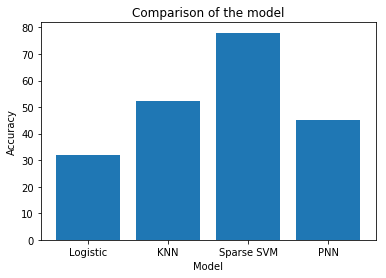

In [55]:
labels = ["Logistic", "KNN", "Sparse SVM", "PNN"]
values = [logisticAccuracy, score, SVMScore, PNNScore]
plt.bar(labels, values)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of the model")
plt.show()

In [67]:
import pickle

fname = "SentimentModel.sav"

with open(fname, 'wb') as fout:
    pickle.dump((vect, clf), fout)